In [ ]:
%pylab inline
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch.utils.data
from PIL import Image
from torchvision import transforms 
from tqdm import tqdm_notebook as tqdm
from facenet_pytorch import MTCNN, InceptionResnetV1

In [ ]:
# 使用cuda运算
os.environ['CUDA_VISIBLE_DEVICES'] ='0' # 设置跑第几个GPU
# device=torch.device("cuda")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

# 读取单张图片 （按照split.txt读取YTF人脸数据）

In [ ]:
mtcnn = MTCNN(device=device)
resnet = InceptionResnetV1(pretrained='vggface2').eval()

In [ ]:
img = Image.open('../aligned_images_DB/Aaron_Eckhart/1/aligned_detect_1.231.jpg')
img = Image.open('./81899286.jpg')
plt.imshow(img)

In [ ]:
# 测试split文件
split_df = pd.read_csv('../splits.txt')
print(split_df.iloc[0, 3])
# sub_df = split_df[split_df['split number'] != 10]
# os.listdir('../frame_images_DB/Carol_Burnett/3')
# sub_df[' first name'].iloc[0]
# sub_df[' second name'].iloc[0]
# sub_df[' is same:'].iloc[0]
# sub_df.iloc[0, 3]
# sub_df.iloc[0, 3]


### 继承Dataset类

In [ ]:
class YouTubeBeDatasetIdentification(torch.utils.data.Dataset):
    def __init__(self, path="../aligned_images_DB", num_frames=5, train=True
                 , person_frames=400, seed=40,step=4, **kwargs):

        """
         Initia the Dataset, load all image path to array.
         Args:
             path (string): Directory with all face images.
             num_frames (int): Frames each person
             train : If traning model
             transform (callable, optional): Optional transform to be applied
                 on a sample.
             person_frames: take how much frames each person (person_frames=person_video*videp_frames)
         """

        # super().__init__(**kwargs)
        path = os.path.abspath(path)
        self.path = path
        self.num_frames = num_frames
        self.step = step
        self.training = train
        self.person_frames = person_frames
        self.seed=seed
        np.random.seed(seed=self.seed)

        self.transforms1 = transforms.Compose([
            #                 transforms.Resize((256,256)),
            transforms.CenterCrop(int(160)),
            transforms.ToTensor(),
            #                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        # get all directories for different people  (include absolute path)
        all_dir = [os.path.join(path, f) for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
        all_dir_path = []
        for person_dir in all_dir:  # person_dir  一个人的视频所在的大文件夹
            path_video_dirs = []
            video_dirs = [d for d in os.listdir(person_dir) if os.path.isdir(os.path.join(person_dir, d))]
            # video_dirs 一个人的所有视频的n个文件夹(not include absolute path)
            video_dirs.sort()
            # 遍历每个人的所有的视频
            for video_dir in video_dirs:
                face_dirs = []
                img_dir = os.path.join(person_dir, video_dir)  # include absolute path
                fs = [f for f in os.listdir(img_dir) if
                      f.lower().endswith('.jpg')]  # get all img  (not include absolute path)
                fs.sort()
                for f in fs:  # 遍历每个视频的所有图片
                    # TODO:   filter some image with a stride
                    #                     index=np.random.choice(len(video_dirs), 1)[0]
                    #                     os.path.join(img_dir,fs[index])
                    face_dirs.append(os.path.join(img_dir, f))

                path_video_dirs.append(face_dirs)
            all_dir_path.append(path_video_dirs)  # put all people face together
        self.all_dir_path = all_dir_path


    def __len__(self):
        return len(self.all_dir_path)*self.person_frames


    def __getitem__(self, idx):
        # 设置每个人取 400张图片
        person_idx = idx // self.person_frames
        label = person_idx
        
        person_dir=self.all_dir_path[person_idx]

        
        idx=np.random.choice(len(person_dir))
        video_dir = person_dir[idx]
        
        idx=np.random.choice(len(video_dir))
        imgpath=video_dir[idx]
        name = os.path.basename(os.path.dirname(os.path.dirname(imgpath)))
        
        img = Image.open(imgpath)
        img = self.transforms1(img)
        img = torch.tensor(img)
        return img,label,name

In [ ]:
batch_size=3
dataset = YouTubeBeDatasetIdentification()
# dataset1 =YouTubeBeDataset()
dataload = torch.utils.data.DataLoader(dataset,shuffle=True,batch_size=batch_size,num_workers=2)
len(dataset)

In [ ]:
g2=iter(dataload)

In [ ]:
%%time
x1,y,name=next(g2)
print('data shape',x1.shape,y)

### 展示数据

In [ ]:
x1_np = x1.numpy().transpose(0,2,3,1)
plt.imshow(x1_np[1])
print("name rank:",y[1],'name:',name[1])

In [ ]:
# img=x1.numpy().transpose(0,1,3,4,2)[0,:]
# # Get cropped and prewhitened image tensor
# # img_cropped = mtcnn(img)

# # Calculate embedding (unsqueeze to add batch dimension)
# img_embedding = resnet(img_cropped.unsqueeze(0))

# # Or, if using for VGGFace2 classification
# resnet.classify = True
# img_probs = resnet(img_cropped.unsqueeze(0))

# 读取RGB和帧间差

In [1]:
%pylab inline
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch.utils.data
from PIL import Image
from torchvision import transforms 

Populating the interactive namespace from numpy and matplotlib


In [2]:
class YTBDatasetCNNwithDisplament(torch.utils.data.Dataset):
    def __init__(self, path="../aligned_images_DB", train=True,step = 6,person_frames=400, seed=40, **kwargs):

        """
         Initia the Dataset, load two kind of training source from image.
         Args:
             path (string): Directory with all face images.
             num_frames (int): Frames each person
             train : If traning model
             transform (callable, optional): Optional transform to be applied
                 on a sample.
             person_frames: take how much frames each person (person_frames=person_video*videp_frames)
         """

        # super().__init__(**kwargs)
        path = os.path.abspath(path)
        self.path = path
        self.step = step
        self.training = train
        self.person_frames = person_frames
        self.seed=seed
        np.random.seed(seed=self.seed)

        self.transforms1 = transforms.Compose([
            #                 transforms.Resize((256,256)),
            transforms.CenterCrop(int(160)),
            transforms.ToTensor(),
#             transforms.Normalize(mean=[104, 117, 128], std=[1]),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        


        # get all directories for different people  (include absolute path)
        all_dir = [os.path.join(path, f) for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
        all_dir_path = []
        for person_dir in all_dir:  # person_dir  一个人的视频所在的大文件夹
            path_video_dirs = []
            video_dirs = [d for d in os.listdir(person_dir) if os.path.isdir(os.path.join(person_dir, d))]
            # video_dirs 一个人的所有视频的n个文件夹(not include absolute path)
            video_dirs.sort()
            # 遍历每个人的所有的视频
            for video_dir in video_dirs:
                face_dirs = []
                img_dir = os.path.join(person_dir, video_dir)  # include absolute path
                fs = [f for f in os.listdir(img_dir) if
                      f.lower().endswith('.jpg')]  # get all img  (not include absolute path)
                fs.sort()
                for f in fs:  # 遍历每个视频的所有图片
                    # TODO:   filter some image with a stride
                    #                     index=np.random.choice(len(video_dirs), 1)[0]
                    #                     os.path.join(img_dir,fs[index])
                    face_dirs.append(os.path.join(img_dir, f))

                path_video_dirs.append(face_dirs)
            all_dir_path.append(path_video_dirs)  # put all people face together
        self.all_dir_path = all_dir_path


    def __len__(self):
        return len(self.all_dir_path)*self.person_frames


    def __getitem__(self, idx):
        # 设置每个人取 400张图片
        person_idx = idx // self.person_frames
        label = person_idx
        
        person_dir=self.all_dir_path[person_idx]

        
        idx=np.random.choice(len(person_dir))
        video_dir = person_dir[idx]
        
        idx=np.random.choice(len(video_dir)-self.step)
        imgpath=video_dir[idx]
        imgpath2=video_dir[idx+self.step]
        
        img = Image.open(imgpath)
        img = self.transforms1(img)
        img2 = Image.open(imgpath2)
        img2 = self.transforms1(img2)
        displacement=img-img2
        return img,displacement,label

In [3]:
batch_size=4
dataset = YTBDatasetCNNwithDisplament()
# dataset1 =YouTubeBeDataset()
dataload = torch.utils.data.DataLoader(dataset,shuffle=True,batch_size=batch_size,num_workers=2)
len(dataset)
generator=iter(dataload)

In [4]:
%%time
x1,d,label=next(generator)
print('data shape',x1.shape,d.shape,label.shape)

data shape torch.Size([4, 3, 160, 160]) torch.Size([4, 3, 160, 160]) torch.Size([4])
CPU times: user 4.02 ms, sys: 4.01 ms, total: 8.03 ms
Wall time: 127 ms


### 展示数据

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


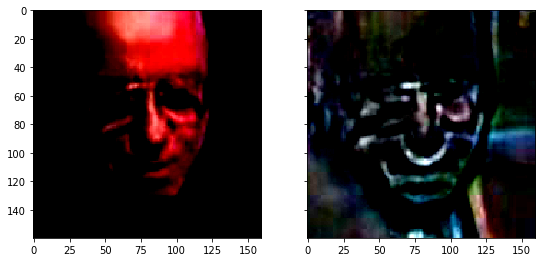

In [5]:
x1,d,label=next(generator)
x1_np = x1.numpy().transpose(0,2,3,1)
d_np= d.numpy().transpose(0,2,3,1)
fig, axs = plt.subplots(1,2, figsize=(9, 9), sharey=True)
axs[0].imshow(x1_np[0])
axs[1].imshow(d_np[0])